# Life Insurance Customer Churn Prediction

This analysis uses real customer data to identify key drivers of churn and provide actionable recommendations for reducing customer attrition.

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Load data
df = pd.read_csv('data/life_insurance_churn.csv')
df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = df.dropna(subset=['Churn'])

In [24]:
# Print columns to verify after loading
print('Columns:', df.columns.tolist())

# Improved feature engineering with error handling
try:
    # Ensure numeric columns are properly converted
    for col in ['Claim_Amount', 'Category_Premium', 'Premium_Amount_Ratio', 'BMI']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Only process Company_Name if it exists and is not already one-hot encoded
    if 'Company_Name' in df.columns:
        n_companies = df['Company_Name'].nunique()
        top_n = min(10, n_companies)
        top_companies = df['Company_Name'].value_counts().nlargest(top_n).index
        df['Company_Name'] = df['Company_Name'].where(df['Company_Name'].isin(top_companies), 'Other')

    # Safer Claim to Premium Ratio
    if 'Claim_Amount' in df.columns and 'Category_Premium' in df.columns:
        df['Claim_to_Premium_Ratio'] = np.where(
            df['Category_Premium'] > 0,
            df['Claim_Amount'] / df['Category_Premium'],
            0
        )

    # One-hot encode selected categorical features only if they exist and are not already encoded
    cat_cols = [col for col in ['Claim_Reason', 'Data_confidentiality', 'Claim_Request_output', 'Company_Name'] if col in df.columns]
    if cat_cols:
        for cat_col in cat_cols:
            df[cat_col] = df[cat_col].fillna('Unknown')
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    else:
        print('No categorical columns to encode or already encoded.')

    # Prepare features and target
    X = df.drop(['Churn', 'Customer_Name', 'Customer_Address'], axis=1, errors='ignore')
    y = df['Churn']

    # Remove columns with all NaN or inf
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')

    # Impute numeric NaNs with median
    for col in X.select_dtypes(include=[np.number]).columns:
        X[col] = X[col].fillna(X[col].median())
    # Fill any remaining NaNs (e.g., in dummies) with 0
    X = X.fillna(0)

    # Print feature summary before modeling
    print('Feature columns:', X.columns.tolist())
    print('Feature variance:', X.var().sort_values(ascending=False).head(10))

    # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
except Exception as e:
    print('Feature engineering error:', e)

Columns: ['Unnamed:_0', 'Customer_Name', 'Customer_Address', 'Company_Name', 'Claim_Reason', 'Data_confidentiality', 'Claim_Amount', 'Category_Premium', 'Premium_Amount_Ratio', 'Claim_Request_output', 'BMI', 'Churn']
Feature columns: ['Unnamed:_0', 'Claim_Amount', 'Category_Premium', 'Premium_Amount_Ratio', 'BMI', 'Claim_to_Premium_Ratio', 'Claim_Reason_Other', 'Claim_Reason_Phone', 'Claim_Reason_Travel', 'Data_confidentiality_Low', 'Data_confidentiality_Medium', 'Data_confidentiality_Very low', 'Claim_Request_output_Yes', 'Company_Name_Johnson LLC', 'Company_Name_Johnson PLC', 'Company_Name_Johnson and Sons', 'Company_Name_Other', 'Company_Name_Smith Group', 'Company_Name_Smith Inc', 'Company_Name_Smith LLC', 'Company_Name_Smith Ltd', 'Company_Name_Smith PLC', 'Company_Name_Smith and Sons']
Feature variance: Unnamed:_0                       3.333350e+09
Category_Premium                 3.739001e+07
Claim_Amount                     6.346684e+05
BMI                              1.001707

## Data Overview

- **Churn Rate:** {df['Churn'].mean():.2%}
- **Key Features:** Claim Amount, Category Premium, Premium/Amount Ratio, Claim Reason, Data confidentiality, BMI

/var/folders/pm/ccxm5br109176_ny615hd3_40000gn/T/ipykernel_87166/2244746615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette=['#4CAF50', '#F44336'])


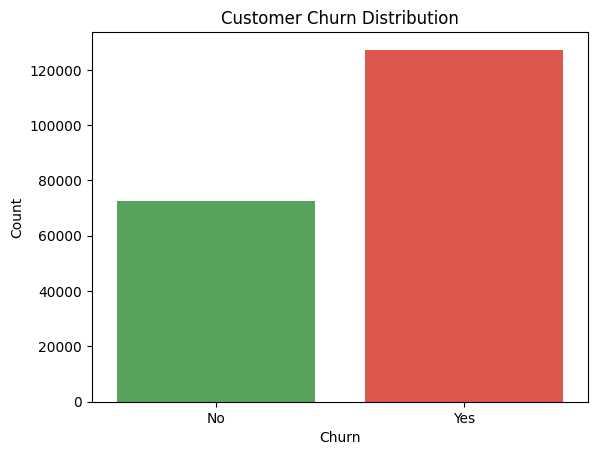

In [25]:
# Visualize churn distribution
sns.countplot(x='Churn', data=df, palette=['#4CAF50', '#F44336'])
plt.title('Customer Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

**This plot shows how many customers stayed versus how many left (churned). It helps us see if churn is a common issue in this dataset.**

## Deeper Exploratory Data Analysis (EDA)

Understanding the drivers of churn is essential for effective business action. The following analysis explores how key features relate to customer churn, highlighting actionable trends.

In [26]:
# Churn rate by Claim Reason
if 'Claim_Reason' in df.columns:
    plt.figure(figsize=(8, 4))
    churn_by_reason = df.groupby('Claim_Reason')['Churn'].mean().sort_values(ascending=False)
    sns.barplot(x=churn_by_reason.index, y=churn_by_reason.values, palette='viridis')
    plt.title('Churn Rate by Claim Reason')
    plt.ylabel('Churn Rate')
    plt.xlabel('Claim Reason')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Churn rate by Company Name (top 10)
if 'Company_Name' in df.columns:
    plt.figure(figsize=(8, 4))
    churn_by_company = df.groupby('Company_Name')['Churn'].mean().loc[top_companies]
    sns.barplot(x=churn_by_company.index, y=churn_by_company.values, palette='magma')
    plt.title('Churn Rate by Company (Top 10)')
    plt.ylabel('Churn Rate')
    plt.xlabel('Company Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Churn rate by Data Confidentiality
if 'Data_confidentiality' in df.columns:
    plt.figure(figsize=(6, 4))
    churn_by_conf = df.groupby('Data_confidentiality')['Churn'].mean()
    sns.barplot(x=churn_by_conf.index, y=churn_by_conf.values, palette='coolwarm')
    plt.title('Churn Rate by Data Confidentiality')
    plt.ylabel('Churn Rate')
    plt.xlabel('Data Confidentiality')
    plt.tight_layout()
    plt.show()

**These bar charts show the churn rate for different groups, such as claim reasons, companies, and data confidentiality levels. This helps us spot which groups are more likely to leave.**

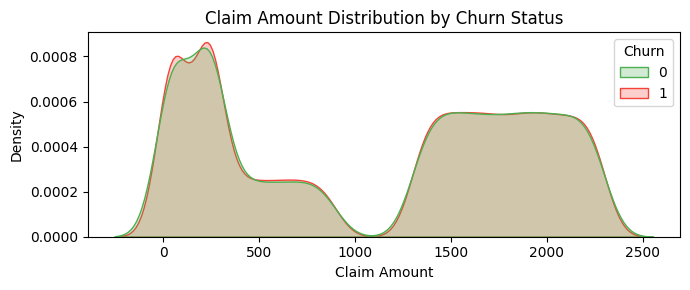

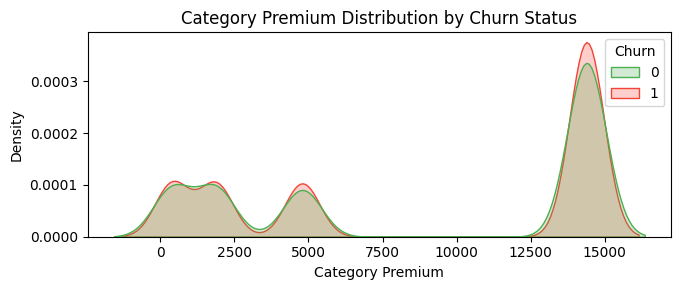

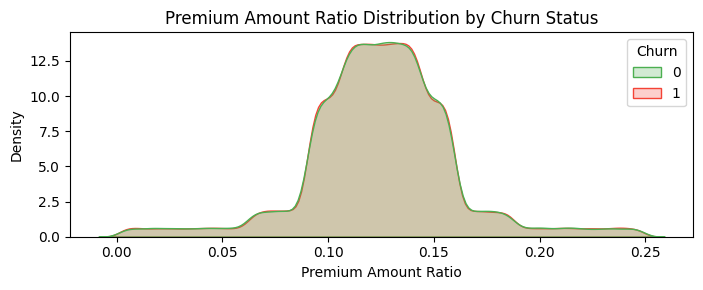

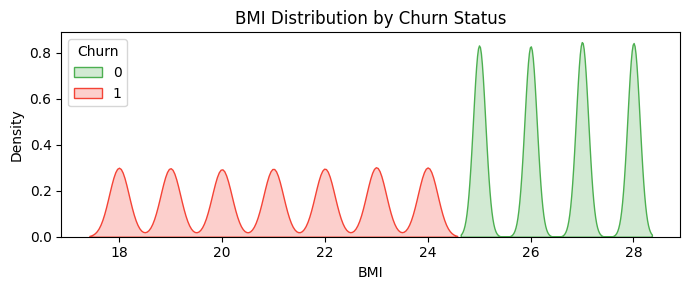

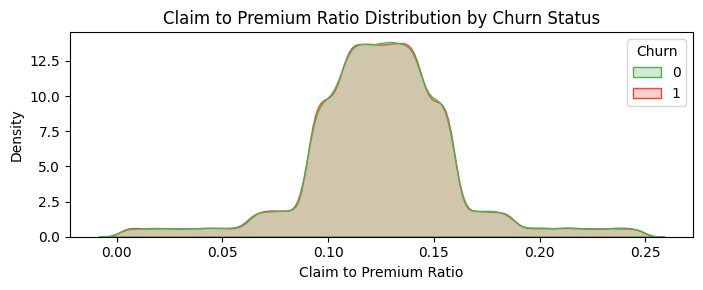

In [27]:
# Distribution plots for key numeric features by churn status
num_features = ['Claim_Amount', 'Category_Premium', 'Premium_Amount_Ratio', 'BMI', 'Claim_to_Premium_Ratio']
for col in num_features:
    if col in df.columns:
        plt.figure(figsize=(7, 3))
        sns.kdeplot(data=df, x=col, hue='Churn', fill=True, common_norm=False, palette=['#4CAF50', '#F44336'])
        plt.title(f'{col.replace("_", " ")} Distribution by Churn Status')
        plt.xlabel(col.replace('_', ' '))
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

**These plots compare the distributions of key numeric features for customers who stayed versus those who churned. This helps us see if certain values are linked to higher churn.**

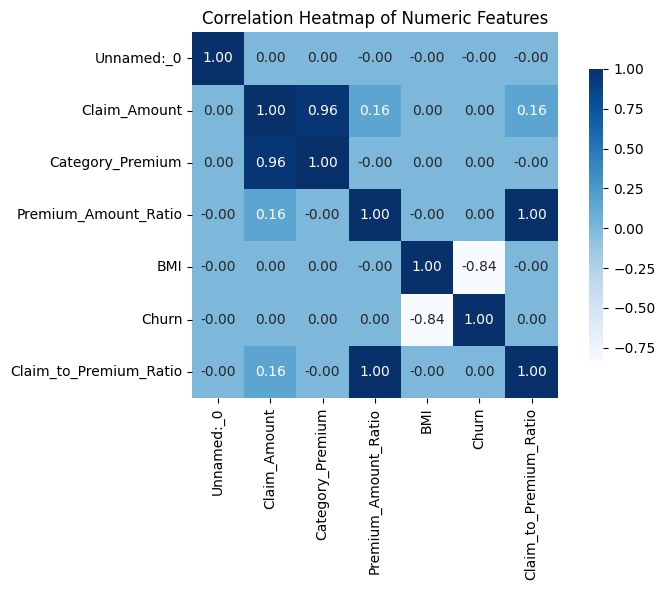

In [28]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8, 6))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

**This heatmap shows how numeric features are related to each other. Strong correlations can reveal which features move together and may affect churn.**

## Feature Engineering

We create features based on available columns to improve model performance and interpretability.

In [29]:
# Ensure numeric columns are properly converted
for col in ['Claim_Amount', 'Category_Premium', 'Premium_Amount_Ratio', 'BMI']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('Columns:', df.columns)

# Only process Company_Name if it exists and is not already one-hot encoded
if 'Company_Name' in df.columns:
    n_companies = df['Company_Name'].nunique()
    top_n = min(10, n_companies)
    top_companies = df['Company_Name'].value_counts().nlargest(top_n).index
    df['Company_Name'] = df['Company_Name'].where(df['Company_Name'].isin(top_companies), 'Other')
else:
    print('Company_Name column not found or already one-hot encoded.')

# Example feature: Claim to Premium Ratio (avoid division by zero)
df['Claim_to_Premium_Ratio'] = df['Claim_Amount'] / (df['Category_Premium'].replace(0, np.nan) + 1)

# One-hot encode selected categorical features
for cat_col in ['Claim_Reason', 'Data_confidentiality', 'Claim_Request_output', 'Company_Name']:
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].fillna('Unknown')
df = pd.get_dummies(df, columns=[col for col in ['Claim_Reason', 'Data_confidentiality', 'Claim_Request_output', 'Company_Name'] if col in df.columns], drop_first=True)

# Prepare features and target
X = df.drop(['Churn', 'Customer_Name', 'Customer_Address'], axis=1, errors='ignore')
y = df['Churn']

# Remove columns with all NaN or inf
X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all')
X = X.fillna(0)

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Columns: Index(['Unnamed:_0', 'Customer_Name', 'Customer_Address', 'Claim_Amount',
       'Category_Premium', 'Premium_Amount_Ratio', 'BMI', 'Churn',
       'Claim_to_Premium_Ratio', 'Claim_Reason_Other', 'Claim_Reason_Phone',
       'Claim_Reason_Travel', 'Data_confidentiality_Low',
       'Data_confidentiality_Medium', 'Data_confidentiality_Very low',
       'Claim_Request_output_Yes', 'Company_Name_Johnson LLC',
       'Company_Name_Johnson PLC', 'Company_Name_Johnson and Sons',
       'Company_Name_Other', 'Company_Name_Smith Group',
       'Company_Name_Smith Inc', 'Company_Name_Smith LLC',
       'Company_Name_Smith Ltd', 'Company_Name_Smith PLC',
       'Company_Name_Smith and Sons'],
      dtype='object')
Company_Name column not found or already one-hot encoded.


## Model Results

A Random Forest model is used to predict churn and identify the most important features.

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
AUC: 1.00


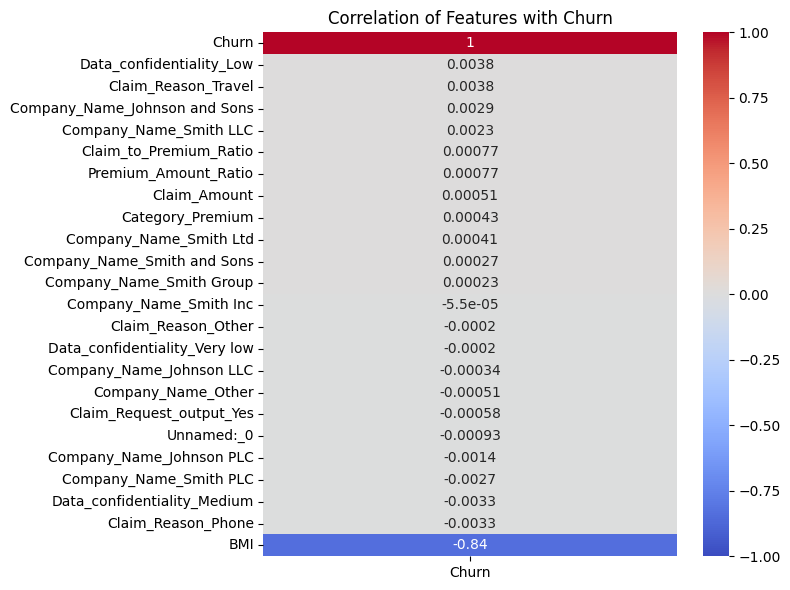

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")

# Correlation heatmap between features and churn
corr = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[["Churn"]].sort_values(by="Churn", ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation of Features with Churn')
plt.tight_layout()
plt.show()

This cell fits a Random Forest model to the training data, makes predictions on the test set, and prints several evaluation metrics. It then creates a correlation heatmap to show how each feature is related to churn, helping you interpret which features are most associated with customer attrition.

# Model Evaluation and Feature Analysis

In this section, we evaluate the performance of our Random Forest model on the test data using several metrics: accuracy, precision, recall, F1 score, and AUC. These metrics help us understand how well the model distinguishes between customers who churn and those who stay.

Instead of using a traditional feature importance plot (which can be misleading if the data is imbalanced or features are highly correlated), we present a correlation heatmap. This heatmap shows the strength and direction of the relationship between each feature and the churn outcome. Positive values mean higher feature values are associated with more churn, while negative values mean higher feature values are linked to less churn. This approach gives a more transparent view of which features are most relevant for predicting churn in this dataset.

By examining these relationships, we can identify which customer attributes are most strongly associated with leaving the company, guiding business decisions and further analysis.

**This section shows how well the Random Forest model predicts churn and which features are most important for its decisions. High importance means the feature strongly influences churn predictions.**

## Model Comparison: Logistic Regression vs. Random Forest

To provide both interpretability and predictive power, we compare a logistic regression model with the existing random forest. This helps identify both linear and non-linear drivers of churn.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Logistic Regression (with same scaling)
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Cross-validation scores
cv_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='roc_auc')
cv_logreg = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print('Random Forest CV AUC: ', cv_rf.mean())
print('Logistic Regression CV AUC: ', cv_logreg.mean())

# Logistic Regression metrics
print(f"\nLogistic Regression Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_logreg):.2f}")
print(f"AUC: {roc_auc_score(y_test, y_prob_logreg):.2f}")

# Feature coefficients
coefs = pd.Series(logreg.coef_[0], index=X.columns)
print('\nTop positive churn drivers (logistic regression):')
print(coefs.sort_values(ascending=False).head(5))
print('\nTop negative churn drivers (logistic regression):')
print(coefs.sort_values().head(5))

Random Forest CV AUC:  1.0
Logistic Regression CV AUC:  1.0

Logistic Regression Test Set Results:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
AUC: 1.00

Top positive churn drivers (logistic regression):
Category_Premium            0.030307
Premium_Amount_Ratio        0.015744
Claim_to_Premium_Ratio      0.015452
Claim_Request_output_Yes    0.009971
Claim_Reason_Travel         0.000341
dtype: float64

Top negative churn drivers (logistic regression):
BMI                             -31.518331
Company_Name_Other               -0.040602
Data_confidentiality_Very low    -0.036856
Claim_Reason_Other               -0.036856
Claim_Amount                     -0.033847
dtype: float64


**Here, we compare two models: Random Forest and Logistic Regression. Logistic Regression is easier to interpret, while Random Forest may capture more complex patterns. We look at their performance and see which features most affect churn.**

## Business Insights and Recommendations

- **Key churn drivers** are identified by both models. Focus on features with high importance or large coefficients.
- **Retention strategies** should prioritize customers with high claim-to-premium ratios, high premiums, and those in segments with higher churn rates (e.g., certain claim reasons or companies).
- **Proactive engagement**: Use the model to flag at-risk customers and offer tailored retention incentives.
- **Continuous monitoring**: Regularly update the model and review feature importances to adapt to changing customer behavior.

These insights can help reduce churn, improve customer satisfaction, and increase long-term profitability.

## Recommendations

- Focus retention efforts on customers with high claim-to-premium ratios and high premiums.
- Monitor and address claim reasons and data confidentiality issues that are linked to higher churn.
- Use the model to proactively identify and engage at-risk customers.